# Berlin Open Data: Kitas

In this notebook I want to explore some data I found on the Berlin open data portal [https://daten.berlin.de](https://daten.berlin.de/). The [data source](https://daten.berlin.de/datensaetze/kitas-berlin) contains informations of Kitas (Kindertagesstätte, i.e. kindergartens) in Berlin. This is a big topic as findng a spot in a Kita is extrmely difficult.

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

%config InlineBackend.figure_format = 'png'

## Read Data

Let us load the data from the orignial Excel file (which I store locally). 

In [2]:
kitas_raw_df = pd.read_excel(
    io='../Data/kitaliste_aktuell.xlsx', 
    skiprows=4, 
    dtype={'PLZ': str}
)

In [3]:
kitas_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2739 entries, 0 to 2738
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Betreuungsbezirk Nr  2739 non-null   int64  
 1   Betreuungsbezirk     2739 non-null   object 
 2   Einrichtungsnummer   2739 non-null   int64  
 3   Einrichtungsname     2739 non-null   object 
 4   Einrichtungsadresse  2739 non-null   object 
 5   PLZ                  2739 non-null   object 
 6   Ort                  2739 non-null   object 
 7   Telefon              2708 non-null   object 
 8   Anzahl Plätze        2736 non-null   float64
 9   Einrichtungsart      2739 non-null   object 
 10  Trägernummer         2739 non-null   int64  
 11  Trägername           2739 non-null   object 
 12  Trägerart            2739 non-null   object 
dtypes: float64(1), int64(3), object(9)
memory usage: 278.3+ KB


In [4]:
kitas_raw_df['Ort'].unique()

array(['Berlin'], dtype=object)

In [5]:
kitas_raw_df[['Betreuungsbezirk Nr', 'Betreuungsbezirk']].drop_duplicates()

,Betreuungsbezirk Nr,Betreuungsbezirk
0,1,Mitte
329,2,Friedrichshain-Kreuzberg
620,3,Pankow
994,4,Charlottenburg-Wilmersdorf
1261,5,Spandau
1403,6,Steglitz-Zehlendorf
1602,7,Tempelhof-Schöneberg
1863,8,Neukölln
2096,9,Treptow-Köpenick
2287,10,Marzahn-Hellersdorf


## Format Data

Next, we format the data and prepare it for the analysis. 

In [6]:
# Rename columns from German to English.
rename_cols = {
    'Betreuungsbezirk': 'district',
    'Einrichtungsnummer': 'id',
    'Einrichtungsname': 'name',
    'Einrichtungsadresse': 'address',
    'PLZ': 'plz',                  
    'Telefon': 'telephone',       
    'Anzahl Plätze': 'spots'  ,
    'Einrichtungsart': 'type',
    'Trägernummer': 'carrier_number',
    'Trägername': 'carrier_name',  
    'Trägerart': 'carrier_type',
}

# Format data: remove redundat columns, rename columns and add new features.
kitas_df = kitas_raw_df \
    .copy() \
    .drop(['Betreuungsbezirk Nr', 'Ort'], axis=1) \
    .rename(columns=rename_cols) \
    .assign(
        num_kitas_plz=lambda x: x.groupby(['district', 'plz'])['id'].transform('count'),
        spots_plz=lambda x: x.groupby(['district', 'plz'])['spots'].transform(np.sum)
    )
    
kitas_df.head()

,district,id,name,address,plz,telephone,spots,type,carrier_number,carrier_name,carrier_type,num_kitas_plz,spots_plz
0,Mitte,1010010,Kita F.A.I.R.play,Albrechtstr. 020,10117,281 64 73,69.0,Kindertagesstätte,1224,GFJ - gemeinnützige Gesellschaft für Familien-...,Sonstiger freier Träger,21,1550.0
1,Mitte,1010020,Kita Kinderwelt,An der Kolonnade 003-5,10117,2291378,155.0,Kindertagesstätte,1334,Forum Soziale Dienste GmbH,Sonstiger freier Träger,21,1550.0
2,Mitte,1010030,FRÖBEL Kindergarten Casa Fantasia,Anklamer Str. 038,10115,4498171,69.0,Kindertagesstätte,1227,Fröbel Bildung und Erziehung gGmbH,Sonstiger freier Träger,24,1807.0
3,Mitte,1010080,Kita Regenbogen,Fehrbelliner Str. 080,10119,449 32 38,91.0,Kindertagesstätte,1202,Pfefferwerk Stadtkultur gGmbH,Sonstiger freier Träger,11,1150.0
4,Mitte,1010100,"FRÖBEL Kindergarten ""Schatzinsel""",Fischerinsel 008,10179,201 37 88,241.0,Kindertagesstätte,1227,Fröbel Bildung und Erziehung gGmbH,Sonstiger freier Träger,10,939.0


## Exploratory Data Analysis

Let us get the number of unique values per feature. 

In [7]:
kitas_df.apply(lambda x: x.unique().size, axis=0)

district            12
id                2739
name              2597
address           2707
plz                190
telephone         2601
spots              200
type                 4
carrier_number    1224
carrier_name      1224
carrier_type         8
num_kitas_plz       37
spots_plz          194
dtype: int64

### Kitas per District

We see that there are Kitas with the same name but which are not the same. We have **2739 Kitas** ni our data set. Let us see their (absolute) distrbuton over districts:

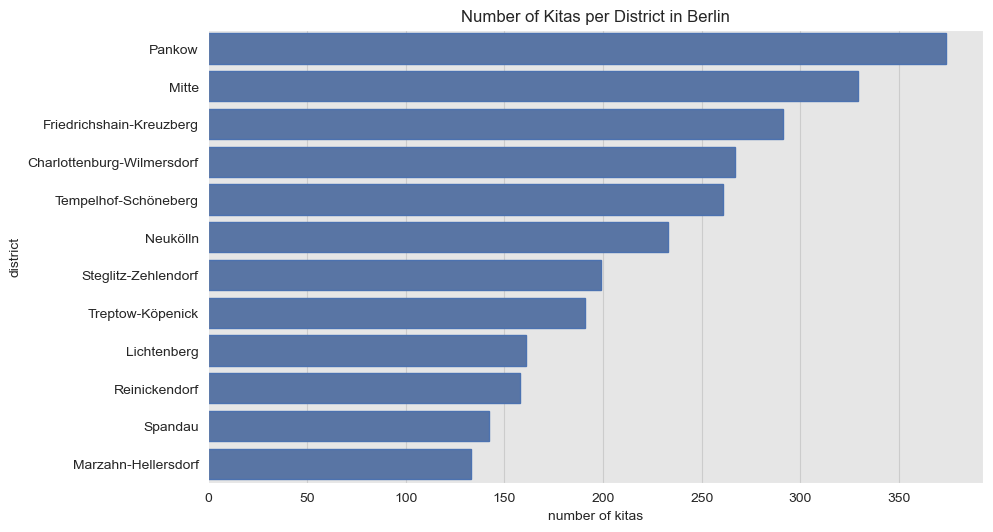

In [8]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['district']) \
    .agg(n=('id', 'count')) \
    .reset_index(drop=False) \
    .sort_values('n', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        x='n', 
        y='district',
        color=sns_c[0],
        edgecolor=sns_c[0],
        ax=ax
    )
ax.set(
    title='Number of Kitas per District in Berlin', 
    xlabel='number of kitas', 
    ylabel='district'
);

We generate the same plot but showing the shares instead. 

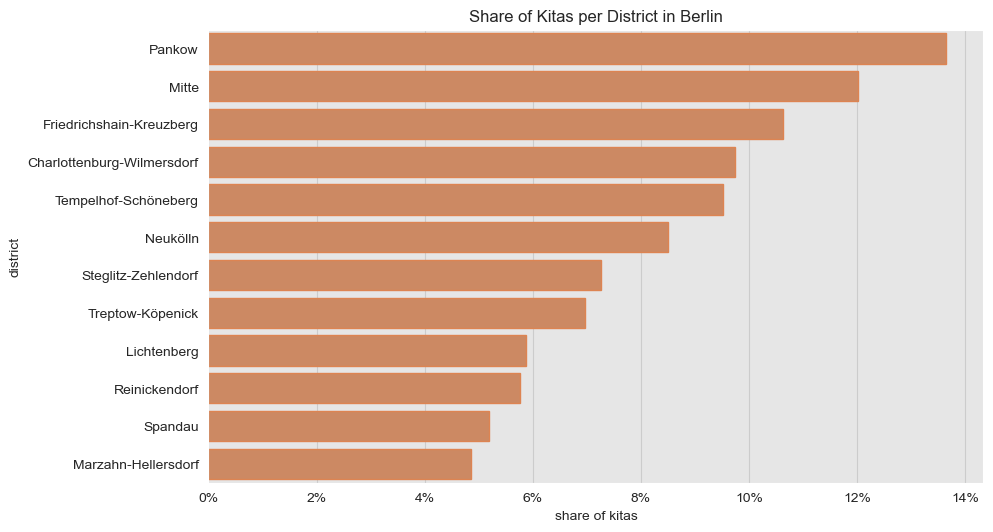

In [9]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['district']) \
    .agg(n=('id', 'count')) \
    .assign(share= lambda x: x['n'] / x['n'].sum()) \
    .reset_index(drop=False) \
    .sort_values('n', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        x='share', 
        y='district',
        color=sns_c[1],
        edgecolor=sns_c[1],
        ax=ax
    )
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:0.0%}'.format(y)))
ax.set(
    title='Share of Kitas per District in Berlin', 
    xlabel='share of kitas', 
    ylabel='district'
);

### Kitas per PLZ

Now we dig deeper into `plz` level. A natural question is: *How many Kitas each `plz` has?* Toa answer it let us look into the distribution (in order to make a fair comparison we need to control by `plz` population or size).

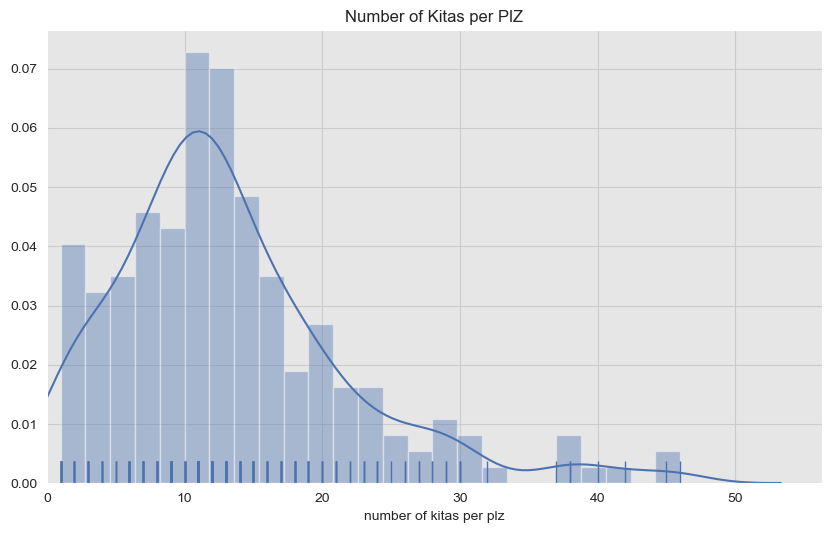

In [10]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['district', 'plz']) \
    .agg(n=('name', 'count')) \
    ['n'] \
    .pipe((sns.distplot, 'a'), 
        bins=25,
        rug=True, 
        ax=ax
    )
ax.set(
    title='Number of Kitas per PlZ', 
     xlabel='number of kitas per plz',
     xlim=(0, None)
);

Let us see the `plz` with more Kitas:

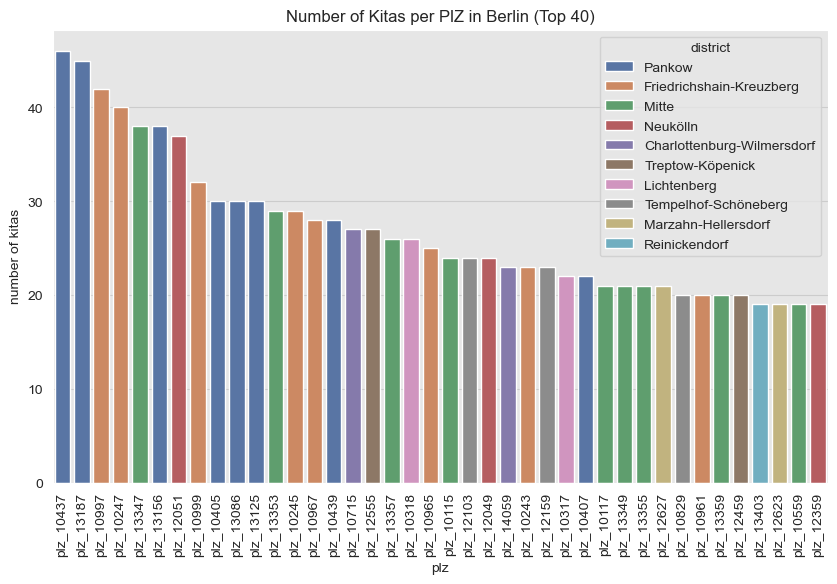

In [11]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['district', 'plz']) \
    .agg(n=('name', 'count')) \
    .reset_index(drop=False) \
    .assign(plz = lambda x: 'plz_' + x['plz'].astype(str)) \
    .sort_values('n', ascending=False) \
    .head(40) \
    .pipe((sns.barplot, 'data'),  
        x='plz',
        y='n',
        hue='district',
        dodge=False,
        ax=ax
    )
ax.tick_params(axis='x', labelrotation=90)
ax.set(
    title='Number of Kitas per PlZ in Berlin (Top 40)', 
     xlabel='plz', 
     ylabel='number of kitas', 
);

Let use where the `plz` = 10437.

<div style="width: 100%">
    <iframe width="100%" height="600" frameborder="0" scrolling="no" marginheight="0" marginwidth="0" src="https://maps.google.com/maps?width=100%25&amp;height=600&amp;hl=en&amp;q=Berlin%2010437+(Berlin%2010437)&amp;t=&amp;z=14&amp;ie=UTF8&amp;iwloc=B&amp;output=embed">
    </iframe>
</div>

Next, let us plot the distribution of the numbler of Kitas per `plz` splitted by `district`.

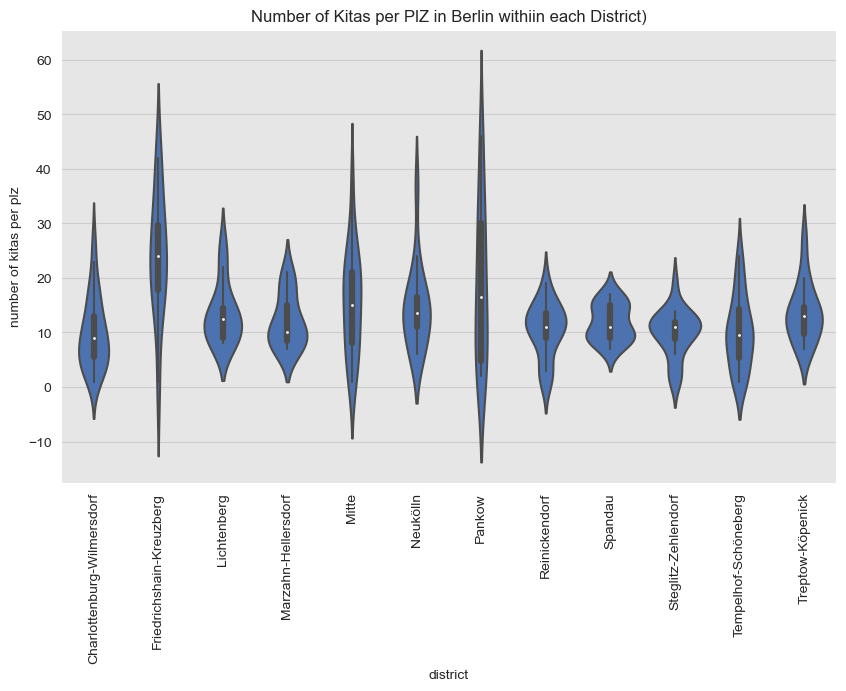

In [12]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['district', 'plz']) \
    .agg(n=('name', 'count')) \
    .reset_index(drop=False) \
    .pipe((sns.violinplot, 'data'), 
        x='district', 
        y='n',
        color=sns_c[0],
        saturation=1.0,
        ax=ax
    )

ax.tick_params(axis='x', labelrotation=90)
ax.set(
    title='Number of Kitas per PlZ in Berlin withiin each District)', 
     ylabel='number of kitas per plz', 
);

It seems that, on average, Friedrichshain-Kreuzberg have more Kitas per `plz` (again, we neet to control by `plz` size to be more precise).

### Spots per Kita

Let us now analize the number of spots data. 

In [13]:
# Some descriptive stats.
kitas_df['spots'].describe()

count    2736.000000
mean       67.617690
std        55.624663
min         0.000000
25%        25.000000
50%        45.000000
75%        95.000000
max       320.000000
Name: spots, dtype: float64

Note that there is a Kita wih `spots`=0. I am not sure about the reason behind this. 

In [14]:
kitas_df.query('spots == 0')

,district,id,name,address,plz,telephone,spots,type,carrier_number,carrier_name,carrier_type,num_kitas_plz,spots_plz
1122,Charlottenburg-Wilmersdorf,4073100,Dickenskita,Dickensweg 017-19,14055,35109330,0.0,Kindertagesstätte,8435,Berlin British School gGmbH,Sonstiger freier Träger,11,500.0


We plot the `spots` distribution:

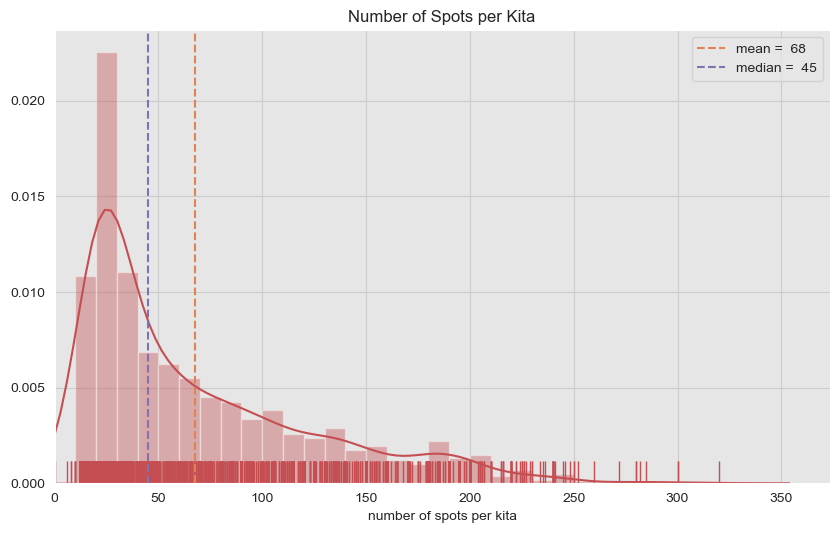

In [15]:
spots_mean = kitas_df['spots'].describe()['mean']
spots_median = kitas_df['spots'].describe()['50%']

fig, ax = plt.subplots()
sns.distplot(a=kitas_df['spots'], rug=True, color=sns_c[3], ax=ax)
ax.axvline(x=spots_mean, color=sns_c[1], linestyle='--', label=f'mean = {spots_mean: 0.0f}')
ax.axvline(x=spots_median, color=sns_c[4], linestyle='--', label=f'median = {spots_median: 0.0f}')
ax.legend(loc='upper right')
ax.set(
    title='Number of Spots per Kita', 
     xlabel='number of spots per kita',
     xlim=(0, None)
);

Here is a list of the top 20 kitas with more spots:

In [16]:
kitas_df \
    [['name', 'district', 'plz', 'spots']] \
    .sort_values('spots', ascending=False) \
    .head(20) 

,name,district,plz,spots
54,BCS Kindergarten Preschool,Mitte,10115,320.0
2441,Kita Lichtenzwerge,Lichtenberg,10315,300.0
2428,Kita Bärenkinder,Lichtenberg,10319,300.0
2543,Kita Neustrelitzer Str. 32-34/Kigä NordOst,Lichtenberg,13055,285.0
2113,FRÖBEL Kindergarten-im-Grünen,Treptow-Köpenick,12487,282.0
647,Klax Krippen Regentropfenhaus und Wolkenzwerge...,Pankow,10439,280.0
1885,Kita Mini-Mix-International,Neukölln,12053,280.0
351,FRÖBEL Kindergarten Am Ring,Friedrichshain-Kreuzberg,10247,272.0
14,"FRÖBEL Kindergarten ""Traumzauberbaum""",Mitte,10178,260.0
2590,Kita Treuenbrietzener Straße,Reinickendorf,13439,252.0


Let us see the `spots` distributoin per district:

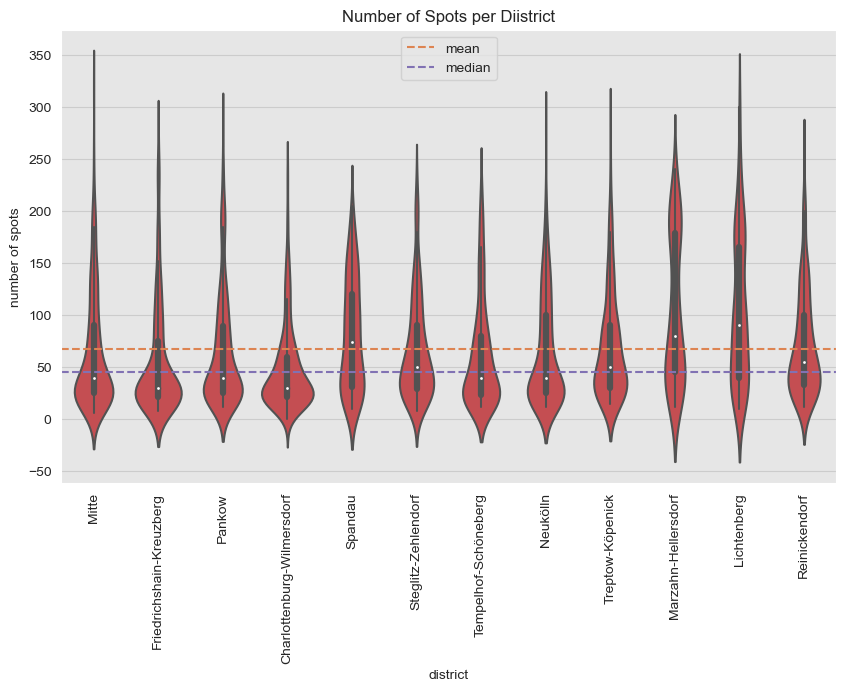

In [17]:
fig, ax = plt.subplots()

kitas_df \
    .pipe((sns.violinplot, 'data'), 
        x='district', 
        y='spots',
        color=sns_c[3],
        saturation=1.0,
        ax=ax
    )
ax.axhline(y=kitas_df['spots'].describe()['mean'], color=sns_c[1], linestyle='--', label='mean')
ax.axhline(y=kitas_df['spots'].describe()['50%'], color=sns_c[4], linestyle='--', label='median')
ax.tick_params(axis='x', labelrotation=90)
ax.legend(loc='upper center')
ax.set(
    title='Number of Spots per Diistrict', 
     ylabel='number of spots', 
);

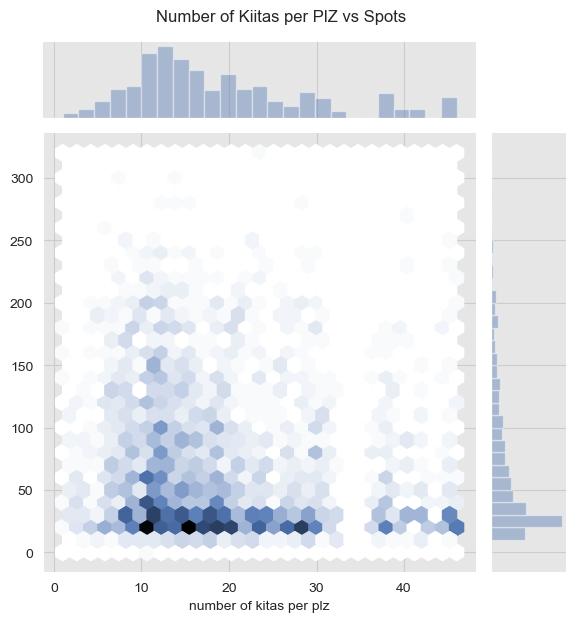

In [18]:
g = sns.jointplot(
    x='num_kitas_plz', 
    y='spots', 
    data=kitas_df, 
    kind='hex',
    joint_kws={'bins': 100}
)
g.set_axis_labels(xlabel='number of kitas per plz')
g.fig.suptitle('Number of Kiitas per PlZ vs Spots', y=1.03);

### Carriers

Now we want to study the `carrier` feature. First, let us count the number of kitas per `carrier_type`.

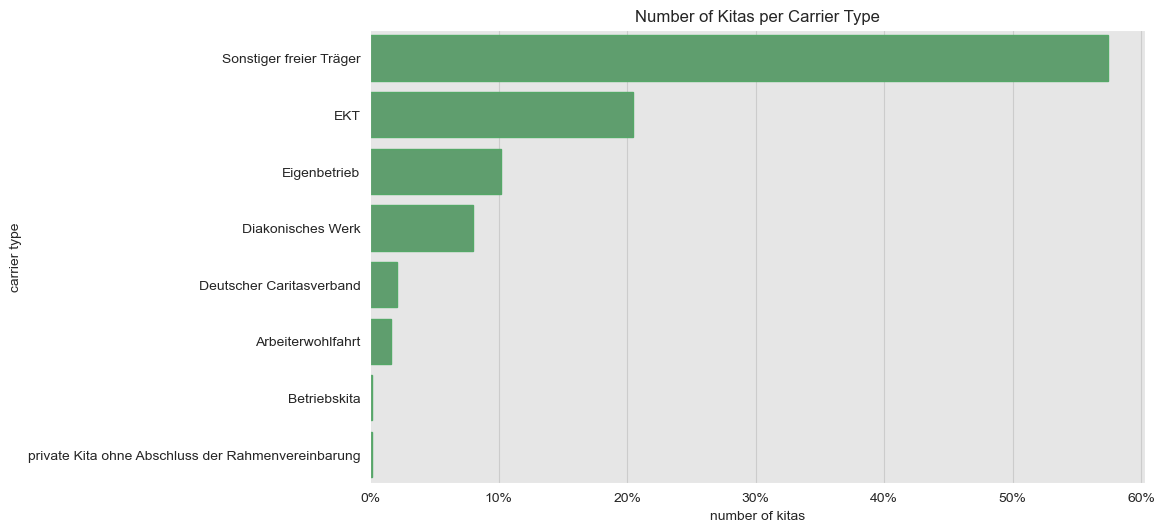

In [19]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['carrier_type']) \
    .agg(n=('id', 'count')) \
    .reset_index() \
    .sort_values('n', ascending=False) \
    .assign(share= lambda x: x['n'] / x['n'].sum()) \
    .pipe((sns.barplot, 'data'), 
        x='share', 
        y='carrier_type',
        color=sns_c[2],
        edgecolor=sns_c[2],
        ax=ax
    )
fmt = lambda y, _: f'{y :0.0%}'
ax.xaxis.set_major_formatter(mtick.FuncFormatter(fmt))
ax.set(
    title='Number of Kitas per Carrier Type', 
    xlabel='number of kitas', 
    ylabel='carrier type'
);

Here are some explanations on the `carrier_type`:

- Arbeiterwohlfahrt: Workers welfare
- Betriebskita: Company daycare
- Deutscher Caritasverband: German Caritas Association
- Eigenbetrieb: Own operation
- EKT (Eltern-Initiativ-Kindertagesstätte): Parents iniitiative. 
- Diakonisches Werk: Diaconal work
- private Kita ohne Abschluss der Rahmenvereinbarung: private daycare without signing the framework agreement
- Sonstiger freier Träger: Other private carrier

Now we plot the `carrier_type` distriibution per `district`.

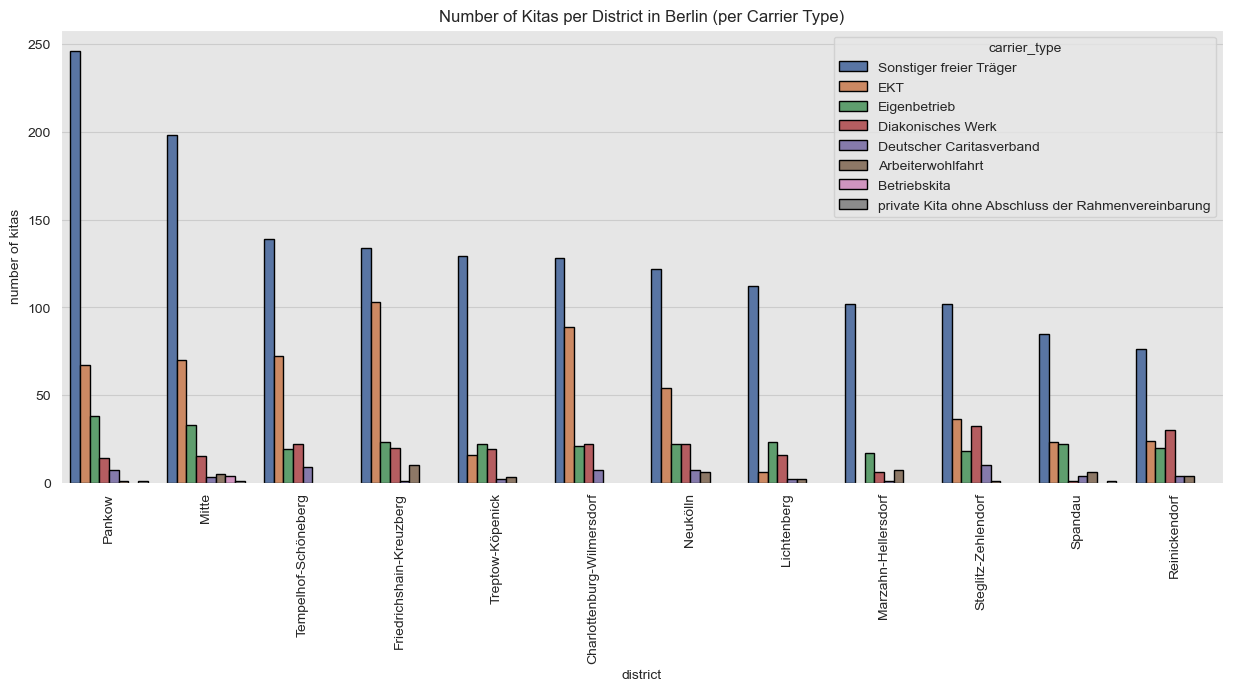

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))

kitas_df \
    .groupby(['district', 'carrier_type']) \
    .agg(n=('id', 'count')) \
    .reset_index(drop=False) \
    .sort_values('n', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        y='n', 
        x='district',
        hue='carrier_type',
        edgecolor='black',
        dodge=True,
        ax=ax
    )
ax.tick_params(axis='x', labelrotation=90)
ax.set(
    title='Number of Kitas per District in Berlin (per Carrier Type)', 
    xlabel='district', 
    ylabel='number of kitas'
);

We can also compute `carrier_type` Kitas share per `district`: 

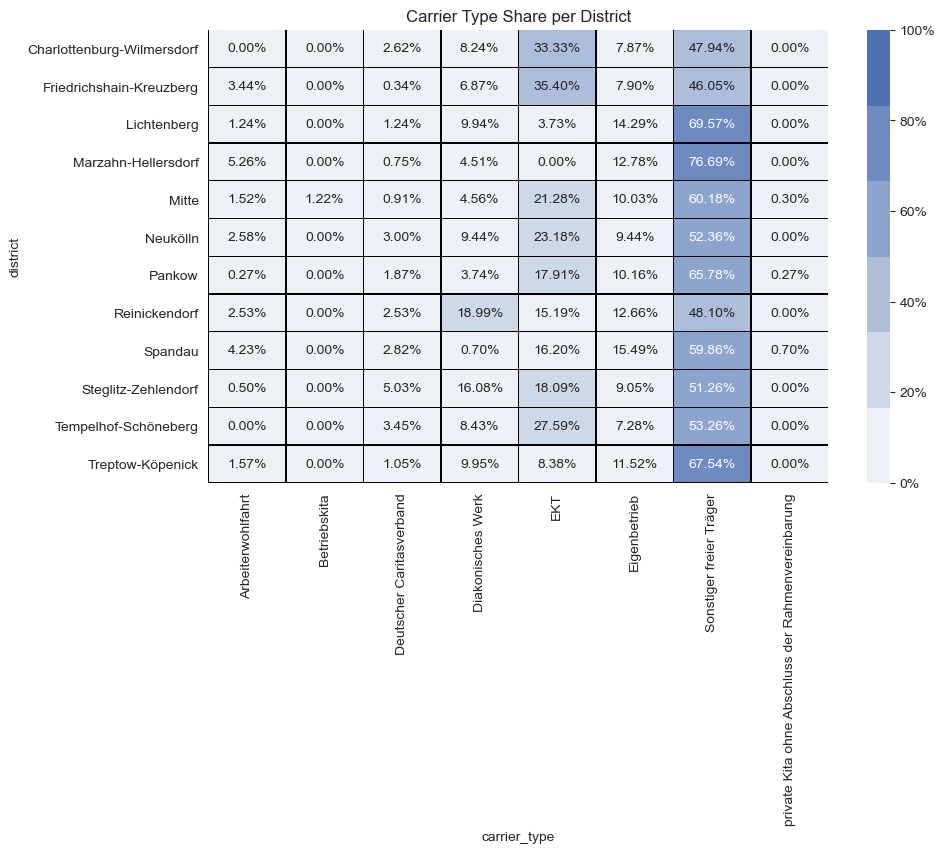

In [21]:
fig, ax = plt.subplots()

cmap = sns.light_palette(sns_c[0])

fmt = lambda y, _: f'{y :0.0%}'

kitas_df \
    .groupby(['district', 'carrier_type']) \
    .agg(n=('id', 'count')) \
    .reset_index(drop=False) \
    .assign(
        num_kitas_district = lambda x: x.groupby(['district'])['n'].transform(np.sum),
        share = lambda x: x['n'].div(x['num_kitas_district'])
    ) \
    .pivot(index='district', columns='carrier_type', values='share') \
    .fillna(0.0) \
    .pipe((sns.heatmap, 'data'), 
        vmin=0.0,
        vmax=1.0,
        cmap=cmap,
        linewidths=0.2, 
        linecolor='black',
        annot=True, 
        fmt='0.2%',
        cbar_kws={'format': mtick.FuncFormatter(fmt)},
        ax=ax
    )

ax.set(title='Carrier Type Share per District');

It is very interestnig to see how high the share of *EKT* in Charlottenburg-Wilmersdorf and Friedrichshain-Kreuzberg.

Now we want to investigate the carriers coverage on the number of kitas. For that we count how many kitas each carrier has and sort them out. In this way we can compute the (cumulative) share on the number of Kitas. 

In [22]:
carrier_df = kitas_df \
    .groupby(['carrier_name']) \
    .agg(num_kitas=('name', pd.Series.nunique)) \
    .sort_values('num_kitas', ascending=False) \
    .assign(
        single_kita = lambda x: x['num_kitas'] < 2,
        share = lambda x: x['num_kitas'] / x['num_kitas'].sum(),
        cumsum_share = lambda x: x['share'].cumsum(),
        idx= lambda x: range(x.shape[0])
    )

In [23]:
# Let us the carriers split having a single Kita. 
carrier_df.groupby('single_kita').agg(n=('idx', 'count'))

,n
single_kita,
False,365
True,859


Next we plot the comulative share data on the number of kitas:

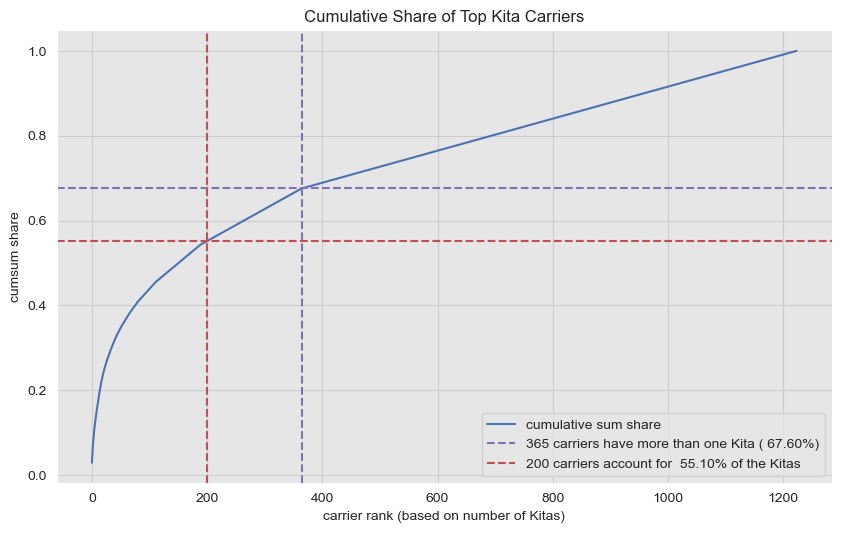

In [24]:
k = 200 
k_cumsum_share = carrier_df.query(f'idx == {k - 1}')['cumsum_share'].values[0]
idx_single_kita = carrier_df.query('single_kita').iloc[0]['idx']
cumsum_share_single_kita = carrier_df.query('single_kita').iloc[0]['cumsum_share']

fig, ax = plt.subplots()
sns.lineplot(x='idx', y='cumsum_share', data=carrier_df, color=sns_c[0], label='cumulative sum share', ax=ax)
ax.axvline(x=idx_single_kita, color=sns_c[4], linestyle='--', label=f'{idx_single_kita} carriers have more than one Kita ({cumsum_share_single_kita: 0.2%})')
ax.axhline(y=cumsum_share_single_kita, color=sns_c[4], linestyle='--')
ax.axvline(x=k, color=sns_c[3], linestyle='--', label=f'{k} carriers account for {k_cumsum_share: 0.2%} of the Kitas')
ax.axhline(y=k_cumsum_share , color=sns_c[3], linestyle='--')
ax.legend(loc='lower right')
ax.set(
    title='Cumulative Share of Top Kita Carriers', 
    xlabel='carrier rank (based on number of Kitas)',
    ylabel='cumsum share'
);

In [25]:
kitas_df = pd.merge(
    left=kitas_df, 
    right=carrier_df['single_kita'].reset_index(), 
    on='carrier_name', 
    how='left'
)

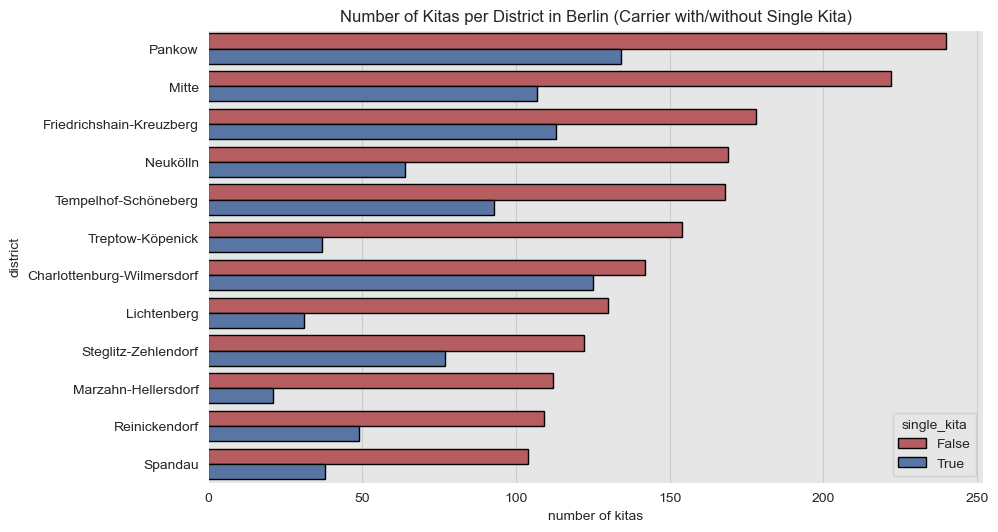

In [26]:
fig, ax = plt.subplots()

kitas_df \
    .groupby(['district', 'single_kita']) \
    .agg(n=('id', 'count')) \
    .reset_index(drop=False) \
    .sort_values('n', ascending=False) \
    .pipe((sns.barplot, 'data'), 
        x='n', 
        y='district',
        hue='single_kita',
        edgecolor='black',
        palette=[sns_c[3], sns_c[0]],
        ax=ax
    )
ax.set(
    title='Number of Kitas per District in Berlin (Carrier with/without Single Kita)', 
    xlabel='number of kitas', 
    ylabel='district'
);

In [27]:
carrier_kitas_df = kitas_df \
    .groupby(['district', 'single_kita']) \
    .agg(n=('id', 'count'), spots=('spots', np.sum)) \
    .reset_index(drop=False) \
    .sort_values('district') \
    .assign(
        total_n = lambda x: x.groupby('district')['n'].transform(np.sum),
        total_spots = lambda x: x.groupby('district')['spots'].transform(np.sum),
        share_n = lambda x: x['n'].div(x['total_n']),
        share_spots = lambda x: x['spots'].div(x['total_spots']),
    )

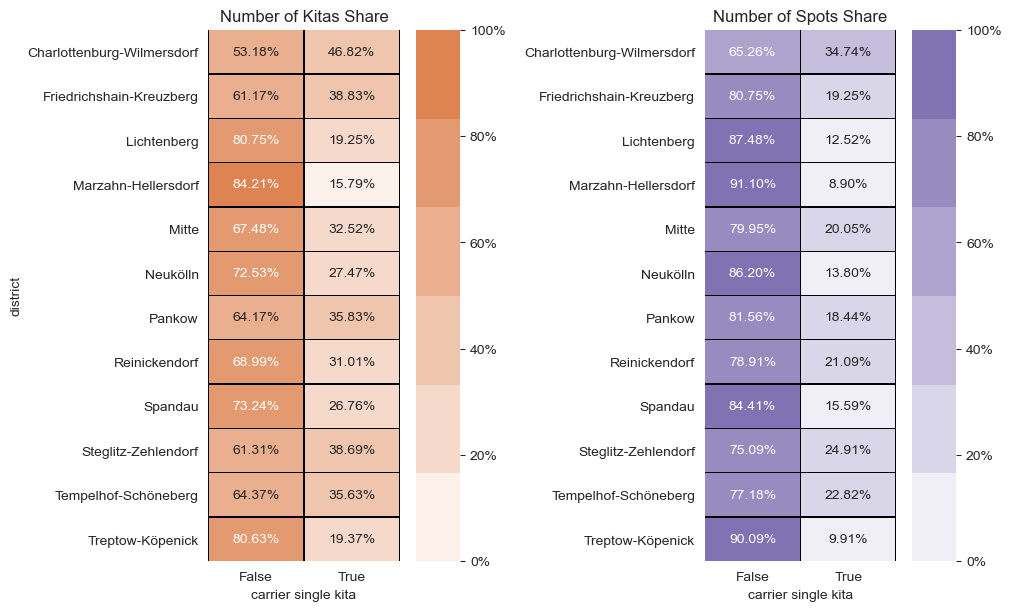

In [28]:
fig, ax = plt.subplots(1, 2, constrained_layout=True)

cmap0 = sns.light_palette(sns_c[1])
cmap1 = sns.light_palette(sns_c[4])

fmt = lambda y, _: f'{y :0.0%}'

carrier_kitas_df \
    .pivot(index='district', columns='single_kita', values='share_n') \
    .pipe((sns.heatmap, 'data'), 
        vmin=0.0,
        vmax=1.0,
        cmap=cmap0,
        linewidths=0.2, 
        linecolor='black',
        annot=True, 
        fmt='0.2%',
        cbar_kws={'format': mtick.FuncFormatter(fmt)},
        ax=ax[0]
    )

carrier_kitas_df \
    .pivot(index='district', columns='single_kita', values='share_spots') \
    .pipe((sns.heatmap, 'data'), 
        vmin=0.0,
        vmax=1.0,
        cmap=cmap1,
        linewidths=0.2, 
        linecolor='black',
        annot=True, 
        fmt='0.2%',
        cbar_kws={'format': mtick.FuncFormatter(fmt)},
        ax=ax[1]
    )

ax[0].set(title='Number of Kitas Share', xlabel='carrier single kita')
ax[1].set(title='Number of Spots Share', xlabel='carrier single kita', ylabel='');

## Maps & Population Data

Next we enrich out data set by including information about population per `plz`. In addition, we use maps to visualize some metrics. Please refer to the blog post [Open Data: Germany Maps Viz](https://juanitorduz.github.io/germany_plots/) for the description of the data sources. 

- Geo-location Data

In [29]:
plz_shape_df = gpd.read_file('../Data/plz-gebiete.shp', dtype={'plz': str})

plz_shape_df.head()

,plz,note,geometry
0,52538,"52538 Gangelt, Selfkant","POLYGON ((5.86632 51.05110, 5.86692 51.05124, ..."
1,47559,47559 Kranenburg,"POLYGON ((5.94504 51.82354, 5.94580 51.82409, ..."
2,52525,"52525 Waldfeucht, Heinsberg","POLYGON ((5.96811 51.05556, 5.96951 51.05660, ..."
3,52074,52074 Aachen,"POLYGON ((5.97486 50.79804, 5.97495 50.79809, ..."
4,52531,52531 Ãbach-Palenberg,"POLYGON ((6.01507 50.94788, 6.03854 50.93561, ..."


- Population Data

In [30]:
plz_einwohner_df = pd.read_csv(
    '../Data/plz_einwohner.csv',
    sep=',',
    dtype={'plz': str, 'einwohner': int}
)

plz_einwohner_df.head()

,plz,einwohner
0,01067,11957
1,01069,25491
2,01097,14811
3,01099,28021
4,01108,5876


- Merge Data

In [31]:
plz_df = pd.merge(
    left=plz_shape_df[['plz', 'geometry']],
    right=plz_einwohner_df,
    on='plz',
    how='left'
)

plz_df = pd.merge(
    left=plz_df,
    right=kitas_df[['district', 'plz', 'num_kitas_plz', 'spots_plz']].drop_duplicates(),
    on='plz',
    how='inner'
)

plz_df = plz_df.assign(
    num_kitas_plz_pc = lambda x: x['num_kitas_plz'].div(x['einwohner']), 
    num_kitas_plz_pc_log = lambda x: np.log(x['num_kitas_plz_pc'])
)

plz_df.head()

,plz,geometry,einwohner,district,num_kitas_plz,spots_plz,num_kitas_plz_pc,num_kitas_plz_pc_log
0,14109,"POLYGON ((13.08835 52.41963, 13.09584 52.42198...",10049,Steglitz-Zehlendorf,8,357.0,0.000796,-7.135787
1,14089,"POLYGON ((13.10929 52.45063, 13.10956 52.45108...",17734,Spandau,15,1112.0,0.000846,-7.075189
2,13591,"POLYGON ((13.11738 52.51706, 13.11811 52.52010...",26762,Spandau,16,1595.0,0.000598,-7.422150
3,13587,"POLYGON ((13.12796 52.58313, 13.12934 52.58593...",20108,Spandau,14,1113.0,0.000696,-7.269816
4,13593,"POLYGON ((13.14288 52.52181, 13.14306 52.52179...",20238,Spandau,9,997.0,0.000445,-7.718093


First, let us visualize the `plz` per `district` in Berlin.

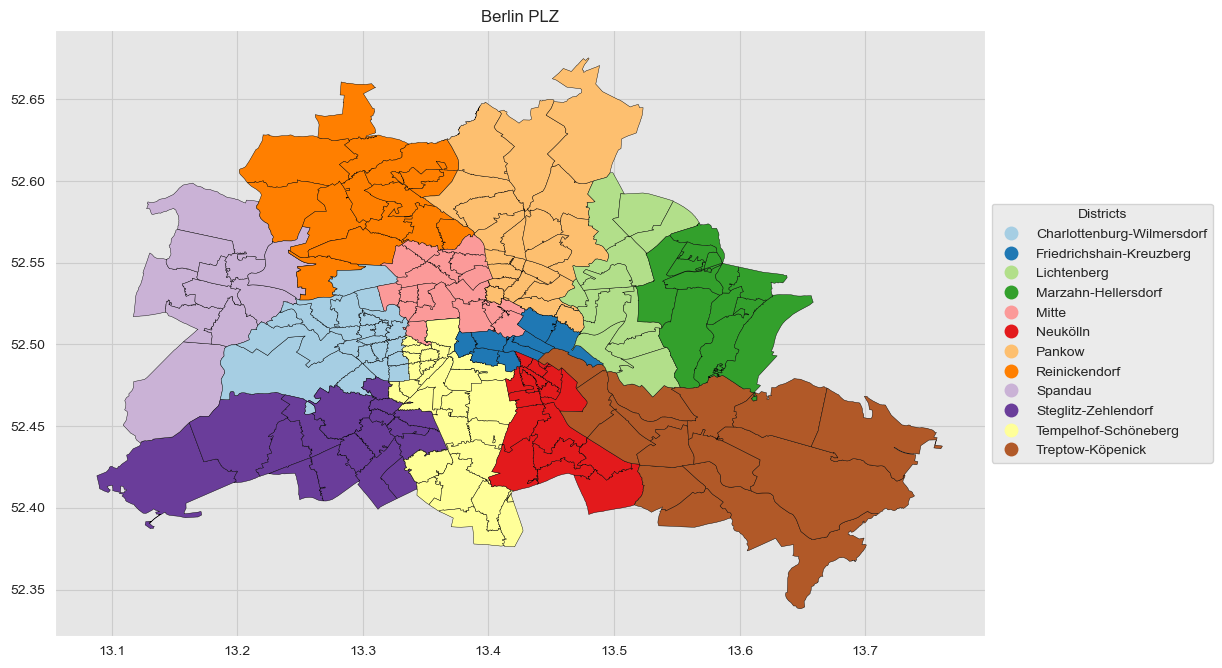

In [32]:
fig, ax = plt.subplots(figsize=(12, 9))

plz_df.plot(
    ax=ax,
    column='district',
    categorical=True,
    cmap='Paired',
    edgecolor='black',
    linewidth=0.3,
    legend=True,
    legend_kwds={'title':'Districts', 'loc': 'center left', 'bbox_to_anchor': (1, 0.5)},
)
ax.set(
    title='Berlin PLZ',
    aspect=1.3
);

Next we plot the number if inhabitants per `plz`.

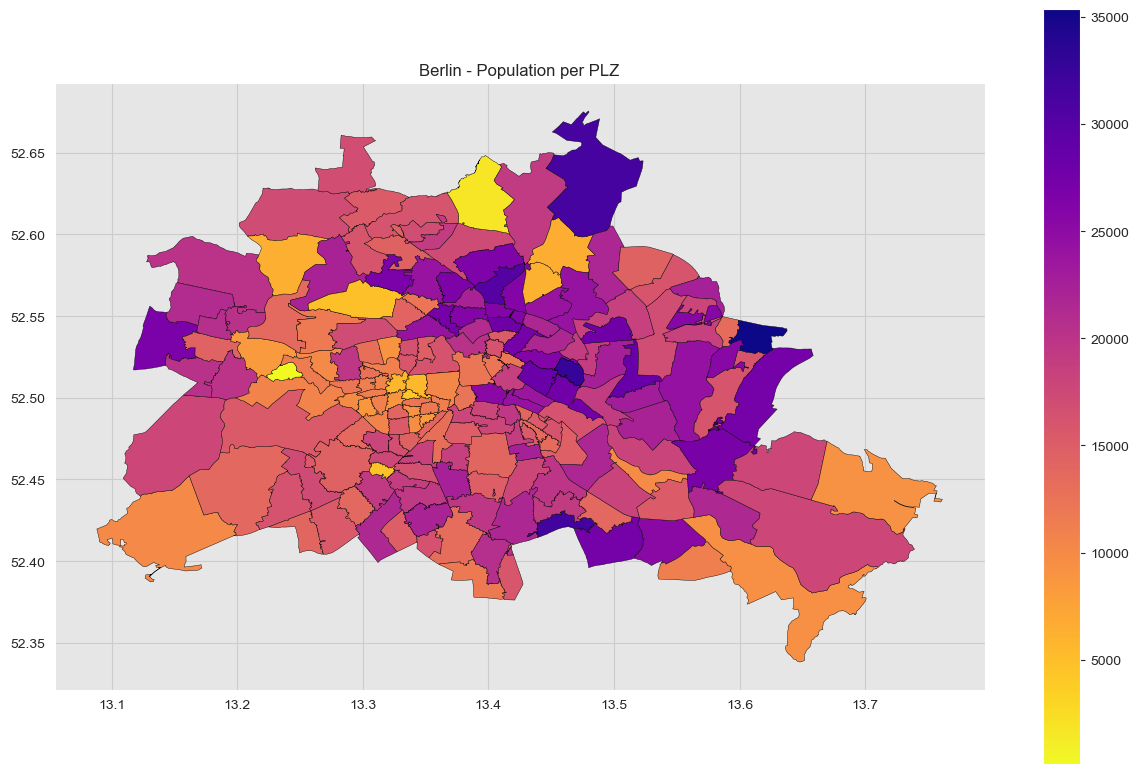

In [33]:
fig, ax = plt.subplots(figsize=(15, 10))

plz_df.plot(
    ax=ax,
    column='einwohner',  
    categorical=False, 
    cmap='plasma_r',
    edgecolor='black',
    linewidth=0.3,
    legend=True,
)
ax.set(
    title='Berlin - Population per PLZ',
    aspect=1.3
);

Now we plot the number of Kitas per `plz`.

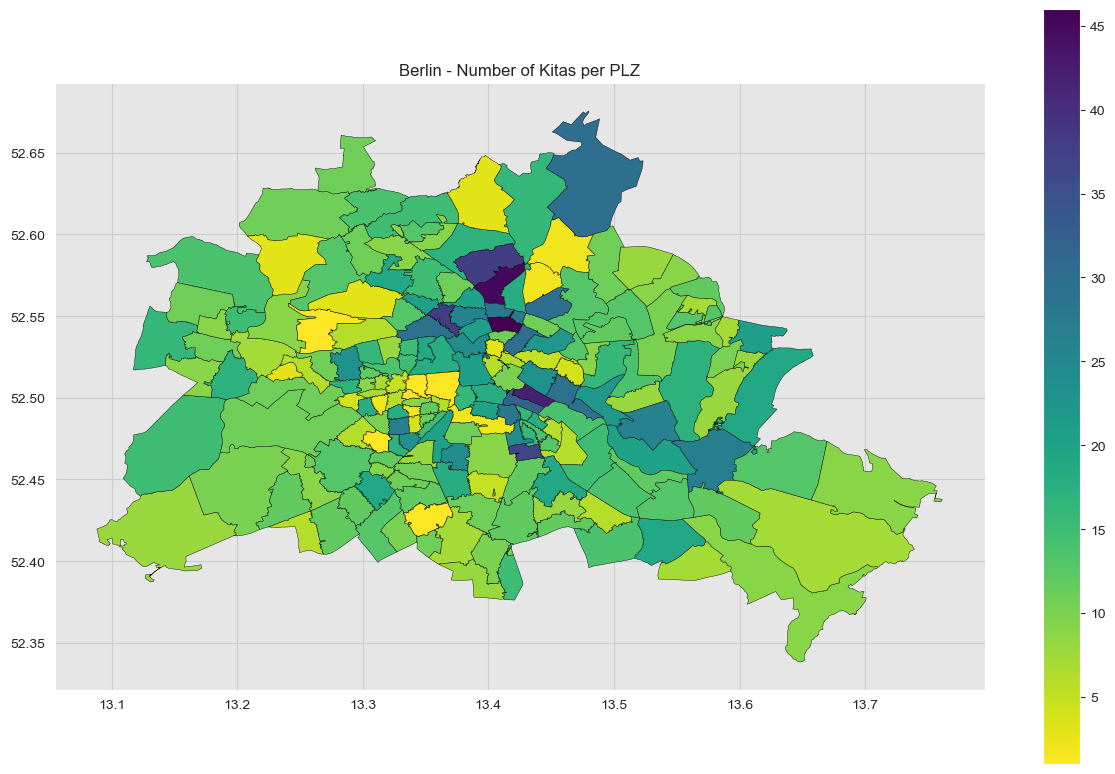

In [34]:
fig, ax = plt.subplots(figsize=(15, 10))

plz_df.plot(
    ax=ax,
    column='num_kitas_plz',
    categorical=False,
    cmap='viridis_r',
    edgecolor='black',
    linewidth=0.3,
    legend=True,
)
ax.set(
    title='Berlin - Number of Kitas per PLZ',
    aspect=1.3
);

Let us not compute the number of Kitas per capita per `district`. 

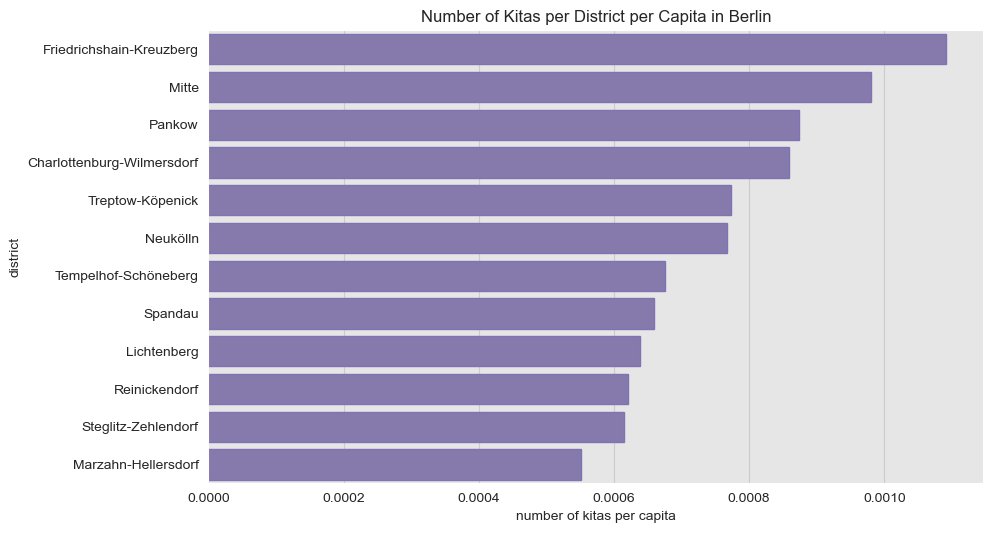

In [35]:
fig, ax = plt.subplots()

plz_df \
    .groupby(['district'], as_index=False) \
    .agg({'einwohner': np.sum, 'num_kitas_plz': np.sum}) \
    .assign(num_kitas_district_pc = lambda x: x['num_kitas_plz'].div(x['einwohner'])) \
    .sort_values('num_kitas_district_pc', ascending=False) \
    .pipe((sns.barplot, 'data'),
        x='num_kitas_district_pc',
        y='district',
        color=sns_c[4],
        edgecolor=sns_c[4],
        ax=ax,
    )

ax.set(
    title='Number of Kitas per District per Capita in Berlin',
    xlabel='number of kitas per capita',
    ylabel='district',
);

Next, we plot the number of Kitas per capita per `plz` (log-transform). 

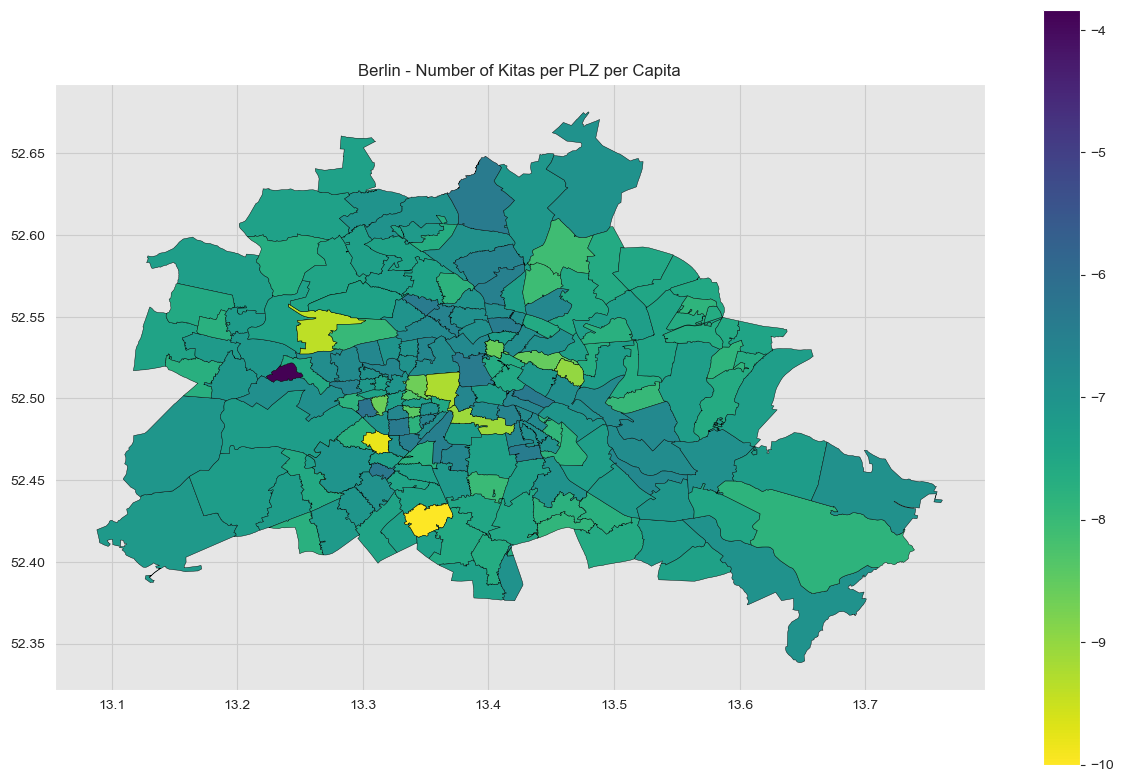

In [36]:
fig, ax = plt.subplots(figsize=(15, 10))

plz_df.plot(
    ax=ax,
    column='num_kitas_plz_pc_log',
    categorical=False,
    cmap='viridis_r',
    edgecolor='black',
    linewidth=0.3,
    legend=True,
)

ax.set(
    title='Berlin - Number of Kitas per PLZ per Capita',
    aspect=1.3
);

In [37]:
plz_df.sort_values('num_kitas_plz_pc', ascending=False).drop('geometry', axis=1).head()

,plz,einwohner,district,num_kitas_plz,spots_plz,num_kitas_plz_pc,num_kitas_plz_pc_log
18,14053,139,Charlottenburg-Wilmersdorf,3,70.0,0.021583,-3.835862
44,10709,8771,Charlottenburg-Wilmersdorf,18,824.0,0.002052,-6.188834
55,12165,4803,Steglitz-Zehlendorf,9,508.0,0.001874,-6.279771
146,10997,23800,Friedrichshain-Kreuzberg,42,1707.0,0.001765,-6.339771
68,10715,15464,Charlottenburg-Wilmersdorf,27,1027.0,0.001746,-6.350433


<div style="width: 100%">
    <iframe width="100%" height="600" frameborder="0" scrolling="no" marginheight="0" marginwidth="0" src="https://maps.google.com/maps?width=100%25&amp;height=600&amp;hl=en&amp;q=Berlin%2014053+(Berlin%2014053)&amp;t=&amp;z=14&amp;ie=UTF8&amp;iwloc=B&amp;output=embed">
    </iframe>
</div>

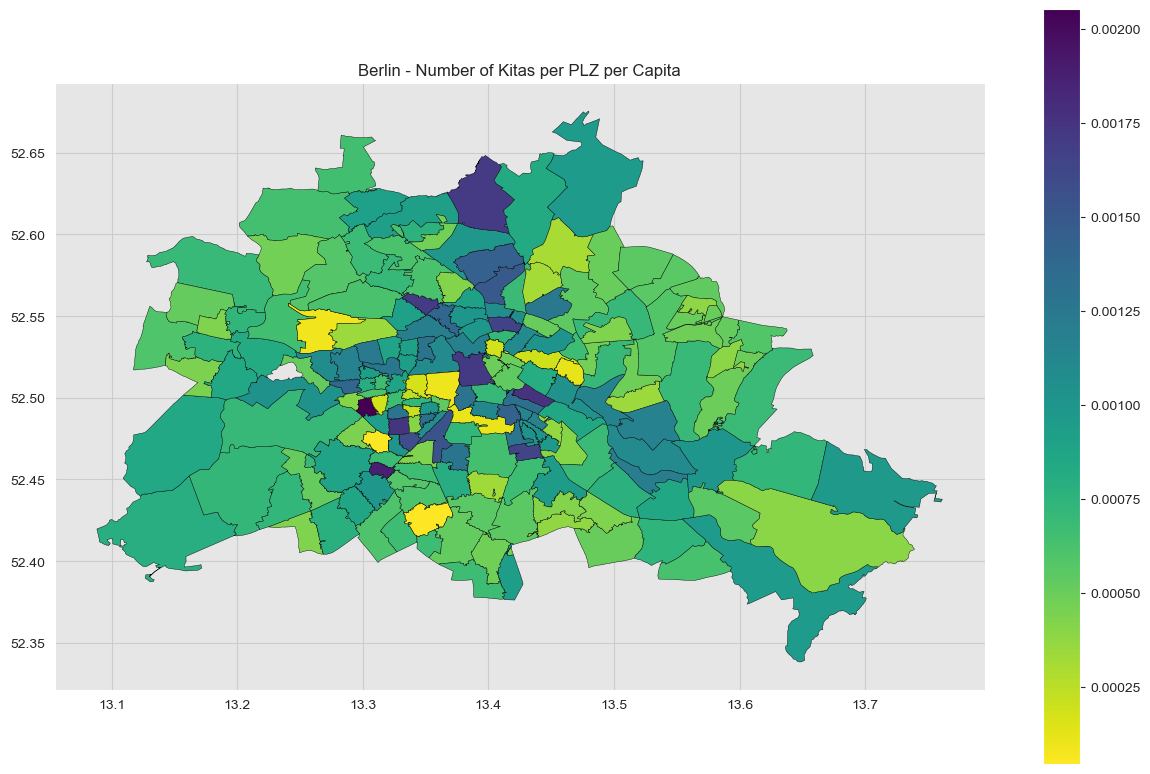

In [38]:
fig, ax = plt.subplots(figsize=(15, 10))

plz_df.query('plz != "14053"').plot(
    ax=ax,
    column='num_kitas_plz_pc',
    categorical=False,
    cmap='viridis_r',
    edgecolor='black',
    linewidth=0.3,
    legend=True,
)

ax.set(
    title='Berlin - Number of Kitas per PLZ per Capita',
    aspect=1.3
);

Finally, let us study the relations between number of kitas, spots and population. These variables are naturally correlated:

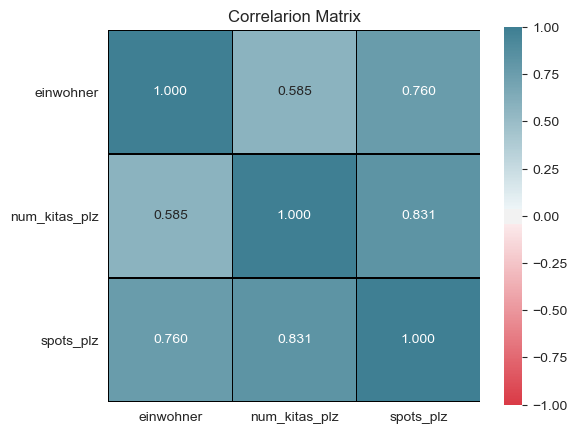

In [39]:
corr_mat = plz_df[['einwohner', 'num_kitas_plz', 'spots_plz']].corr()

fig, ax = plt.subplots(figsize=(6, 5))

cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(
    data=corr_mat, 
    vmin=-1.0, 
    vmax=1.0, 
    center=0, 
    cmap=cmap, 
    square=True,
    linewidths=0.5, 
    linecolor='k',
    annot=True, 
    fmt='.3f',
    ax=ax
)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
ax.set_xticklabels(ax.get_yticklabels(), horizontalalignment='center')
ax.set(title='Correlarion Matrix');

We can visualize them as in a scatter plot.

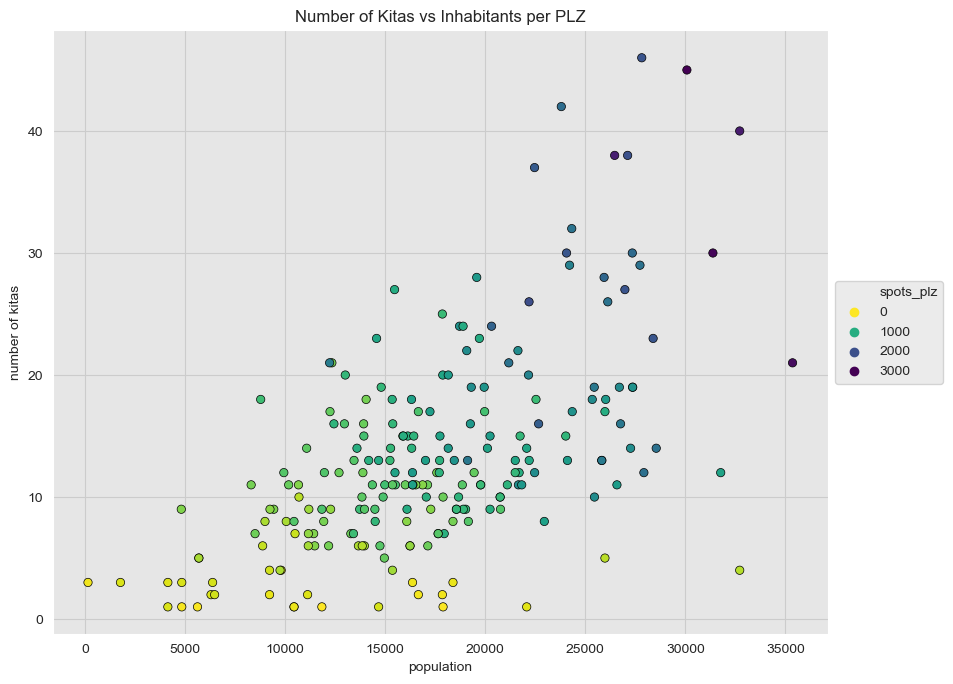

In [40]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.scatterplot(
    x='einwohner',
    y='num_kitas_plz',
    data=plz_df,
    hue='spots_plz',
    palette='viridis_r',
    edgecolor='black',
    linewidth=0.5,
    ax=ax
)
ax.legend(**{'loc': 'center left', 'bbox_to_anchor': (1, 0.5)})
ax.set(
    title='Number of Kitas vs Inhabitants per PLZ',
    xlabel='population',
    ylabel='number of kitas'
);

Let us encode the `district` as color and `spots` as size.

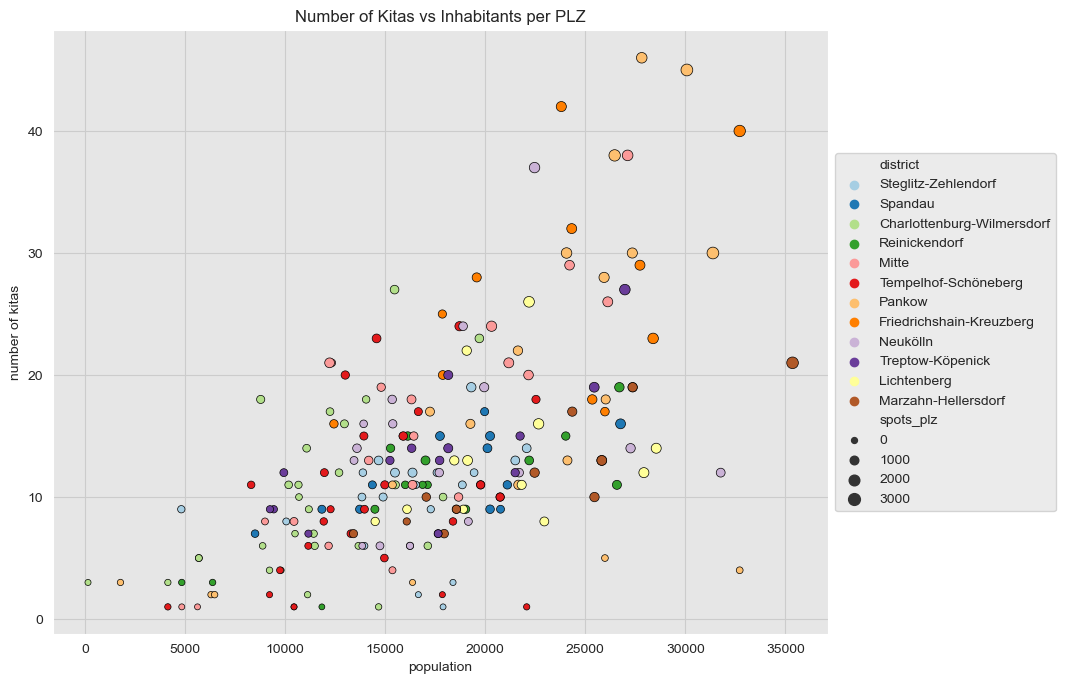

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.scatterplot(
    x='einwohner',
    y='num_kitas_plz',
    data=plz_df,
    hue='district',
    palette='Paired',
    edgecolor='black',
    linewidth=0.5,
    size='spots_plz',
    ax=ax
)
ax.legend(**{'loc': 'center left', 'bbox_to_anchor': (1, 0.5)})
ax.set(
    title='Number of Kitas vs Inhabitants per PLZ',
    xlabel='population',
    ylabel='number of kitas'
);

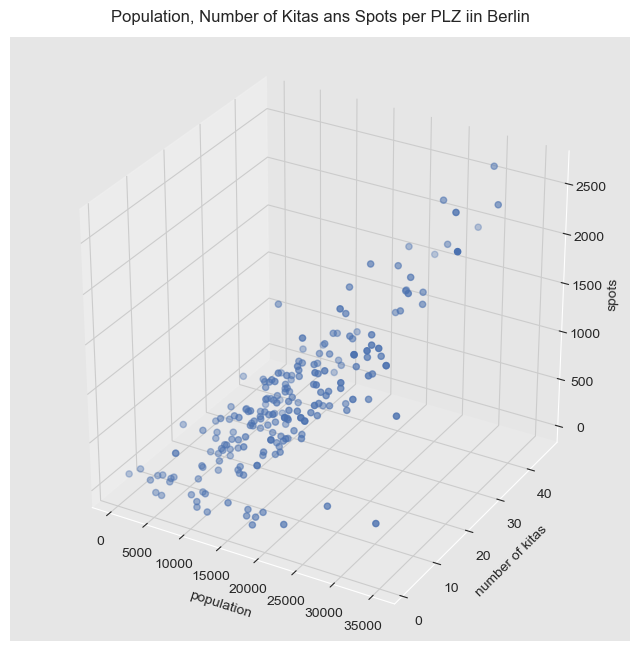

In [42]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import to_hex

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    xs=plz_df['einwohner'], 
    ys=plz_df['num_kitas_plz'], 
    zs=plz_df['spots_plz'], 
    c=to_hex(sns_c[0])
)
ax.set_title('Population, Number of Kitas ans Spots per PLZ iin Berlin', y=1.1);
ax.set(xlabel='population', ylabel='number of kitas', zlabel='spots');

## Linear Regression Model

In [43]:
import statsmodels.formula.api as smf

model = smf.ols(formula='num_kitas_plz ~ einwohner + C(district)', data=plz_df)

result = model.fit()

print(result.summary())

OLS Regression Results                            
Dep. Variable:          num_kitas_plz   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     14.00
Date:                Sun, 06 Sep 2020   Prob (F-statistic):           6.33e-21
Time:                        22:11:39   Log-Likelihood:                -696.16
No. Observations:                 214   AIC:                             1418.
Df Residuals:                     201   BIC:                             1462.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept             

In [44]:
plz_model_df = pd.concat([plz_df, result.get_prediction(plz_df).summary_frame()], axis=1)

plz_model_df = plz_model_df.assign(error = lambda x: x['mean'] - x['num_kitas_plz'])

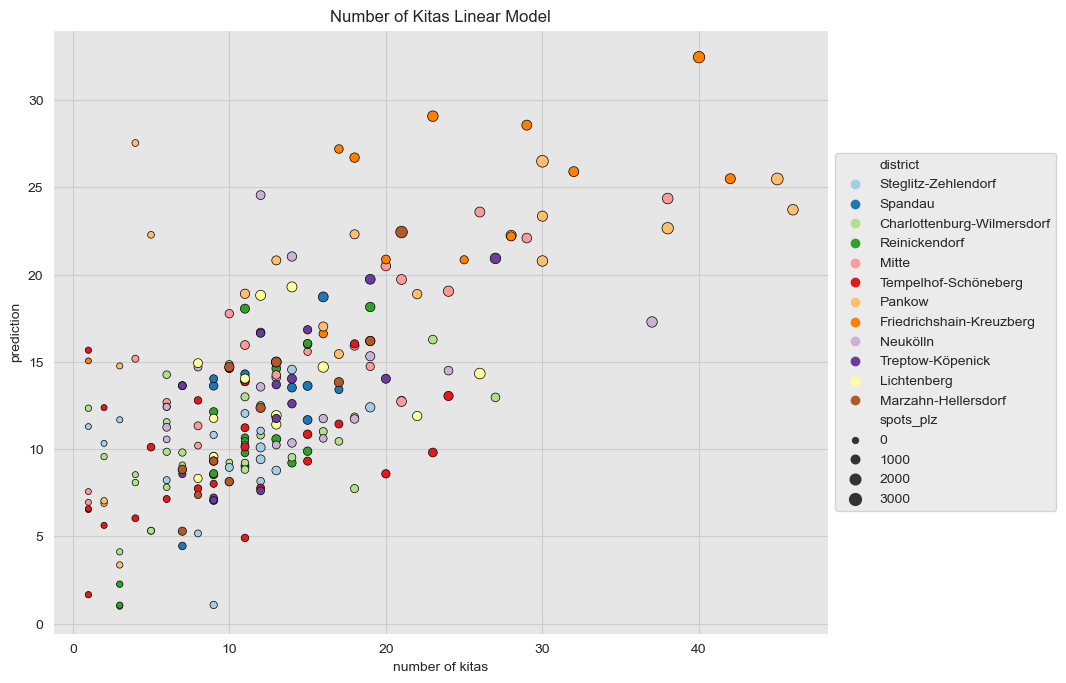

In [45]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.scatterplot(
    x='num_kitas_plz',
    y='mean',
    data=plz_model_df,
    hue='district',
    palette='Paired',
    edgecolor='black',
    linewidth=0.5,
    size='spots_plz',
    ax=ax
)

ax.legend(**{'loc': 'center left', 'bbox_to_anchor': (1, 0.5)})
ax.set(
    title='Number of Kitas Linear Model',
    xlabel='number of kitas',
    ylabel='prediction'
);

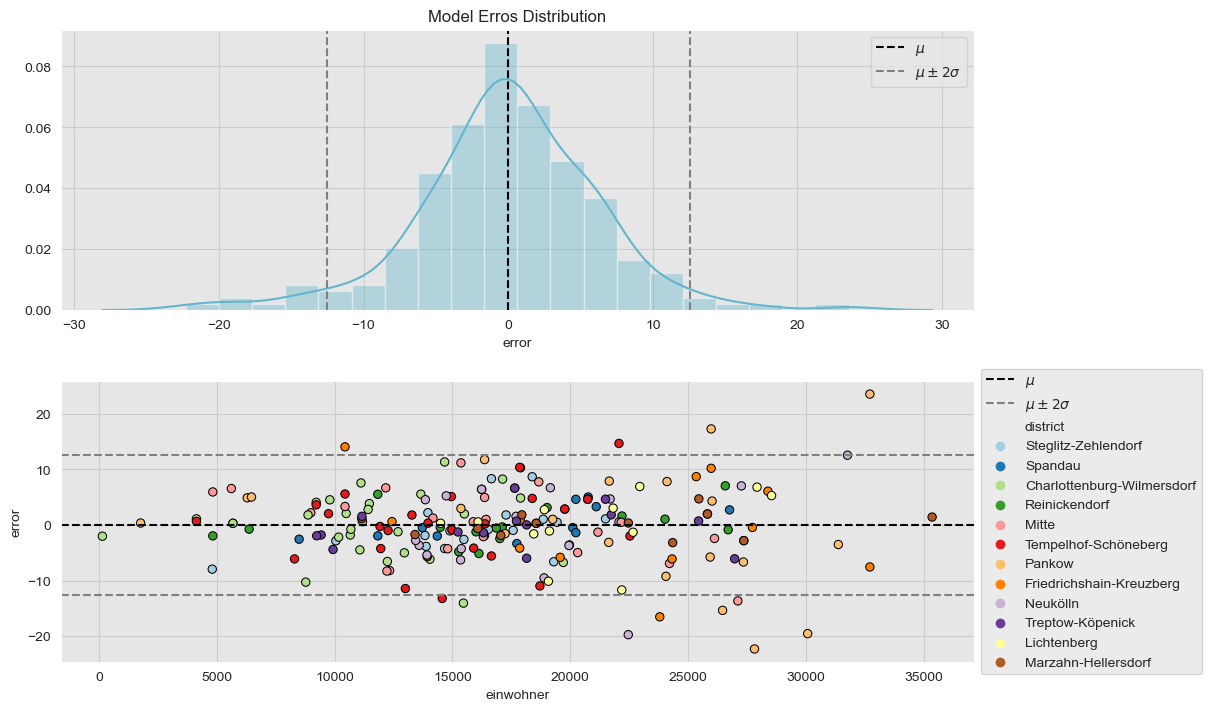

In [54]:
error_mean = plz_model_df['error'].mean()
error_std = plz_model_df['error'].std()

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 7), constrained_layout=True)
sns.distplot(a=plz_model_df['error'], color=sns_c[9], ax=ax[0])
ax[0].axvline(x=error_mean, color='black', linestyle='--', label=f'$\mu$')
ax[0].axvline(x=error_mean + 2*error_std, color='gray', linestyle='--', label=f'$\mu\pm2\sigma$')
ax[0].axvline(x=error_mean - 2*error_std, color='gray', linestyle='--')
sns.scatterplot(x='einwohner', y='error', data=plz_model_df, hue='district', palette='Paired', edgecolor='black', ax=ax[1])
ax[1].axhline(y=error_mean, color='black', linestyle='--', label=f'$\mu$')
ax[1].axhline(y=error_mean + 2*error_std, color='gray', linestyle='--', label=f'$\mu\pm2\sigma$')
ax[1].axhline(y=error_mean - 2*error_std, color='gray', linestyle='--')

ax[0].legend()
ax[1].legend(**{'loc': 'center left', 'bbox_to_anchor': (1, 0.5)})
ax[0].set(title='Model Erros Distribution');